### Paquetes necesarios

Para asegurar el correcto funcionamiento del notebook, primero importamos todos los paquetes necesarios. Estos incluyen herramientas para procesamiento de imágenes, manejo de archivos, cálculos matemáticos, gestión de rutas y tiempo, así como librerías específicas para detección de objetos y OCR.

In [13]:
import cv2  
import math 
import os
import shutil
import random
from pathlib import Path
import yaml
from ultralytics import YOLO
import pandas as pd
import time
import easyocr
import matplotlib.pyplot as plt


### Detección de matrícula, desenfoque y reconocimiento de texto

Este bloque realiza la detección de matrículas en un vídeo, aplica un desenfoque sobre ellas y extrae el texto usando OCR. El proceso se divide en varias etapas:

1. **Configuración inicial**:  
   Se definen las rutas del modelo YOLO entrenado, el vídeo de entrada, el vídeo de salida, el archivo CSV donde se guardarán los resultados y el tamaño del kernel de desenfoque.  

2. **Inicialización de modelos**:  
   Se carga el modelo YOLO para detección de matrículas y se inicializa EasyOCR para el reconocimiento de texto en las regiones detectadas.

3. **Procesamiento del vídeo**:  
   Se abre el vídeo de entrada y se obtiene información como el número de fotogramas por segundo y las dimensiones del vídeo. También se prepara un `VideoWriter` para guardar el vídeo resultante.

4. **Creación del CSV**:  
   Se define un DataFrame con columnas que almacenarán información por cada objeto detectado, incluyendo coordenadas, tipo de objeto, confianza, coordenadas de la matrícula y el texto reconocido.

5. **Iteración fotograma a fotograma**:  
   Para cada fotograma del vídeo:
   - Se realiza la detección de objetos con YOLO.
   - Para cada objeto detectado, se extraen las coordenadas y la clase.
   - Si el objeto es una matrícula:
     - Se aplica un padding a la región de interés para que el OCR no corte los bordes.
     - Se convierte a escala de grises y se aplica un umbral adaptativo para mejorar el reconocimiento.
     - Se ejecuta EasyOCR sobre la región, guardando el texto reconocido.
     - Posteriormente, se aplica un desenfoque Gaussiano sobre la matrícula en el fotograma.
   - Se dibujan rectángulos alrededor de todos los objetos detectados, diferenciando visualmente las matrículas.
   - Se almacena toda la información relevante en el DataFrame.

6. **Guardar resultados**:  
   - Se escribe cada fotograma procesado en el vídeo de salida.
   - Al finalizar, se guarda el DataFrame como CSV con toda la información de detección y OCR.

7. **Reporte final**:  
   Se calcula el tiempo promedio de inferencia por fotograma y se imprime un resumen con la ubicación del vídeo procesado y del CSV generado.


In [ ]:
import cv2
import time
import pandas as pd
from ultralytics import YOLO
import easyocr
import pytesseract
import os
import numpy as np

# ===== CONFIG =====
model_personas_coches_path = "yolo11n.pt"  # Modelo general
model_matriculas_path = "matriculas_train/weights/best.pt"  # Modelo de matrículas
video_input = "C0142.MP4"
video_output = "video_resultado_final_blur.mp4"
csv_output = "CSVs/resultados_final_blur.csv"
blur_kernel = (25, 25)

# ===== Inicializar modelos =====
model_general = YOLO(model_personas_coches_path)
model_matriculas = YOLO(model_matriculas_path)

# Desactivar logs
model_general.overrides['verbose'] = False
model_matriculas.overrides['verbose'] = False

# ===== Inicializar OCR =====
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
reader = easyocr.Reader(['es'], gpu=True)

# ===== Crear carpetas =====
os.makedirs("matriculas_detectadas", exist_ok=True)
os.makedirs("CSVs", exist_ok=True)

# ===== Abrir vídeo =====
cap = cv2.VideoCapture(video_input)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(video_output, fourcc, fps, (width, height))

# ===== DataFrames =====
columns = ["frame", "id_tracking", "tipo_objeto", "confianza", "x1","y1","x2","y2", "texto_matricula"]
df_easy = pd.DataFrame(columns=columns)
df_tesseract = pd.DataFrame(columns=columns)

# ===== Tracking =====
object_counts = {"person": 0, "car": 0, "matricula": 0}
unique_ids = set()
frame_idx = 0
tiempos = []

# ===== PROCESAMIENTO =====
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    start_time = time.time()

    # Copia limpia del frame antes del blur
    frame_original = frame.copy()

    # ===== DETECCIÓN DE MATRÍCULAS =====
    results_matriculas = model_matriculas(frame_original)[0]
    for box in results_matriculas.boxes:
        cls_id = int(box.cls[0])
        tipo = model_matriculas.names[cls_id]
        if tipo.lower() != "matricula":
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        object_counts["matricula"] += 1

        pad = 5
        y1_p, y2_p = max(0, y1-pad), min(frame.shape[0], y2+pad)
        x1_p, x2_p = max(0, x1-pad), min(frame.shape[1], x2+pad)
        roi = frame_original[y1_p:y2_p, x1_p:x2_p]

        if roi.size == 0:
            continue

        # === Preprocesamiento OCR ===
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        scale = 300 / roi_gray.shape[1]
        roi_gray = cv2.resize(roi_gray, (300, int(roi_gray.shape[0] * scale)))
        roi_bin = cv2.adaptiveThreshold(roi_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        roi_bin = cv2.dilate(roi_bin, kernel, iterations=1)

        # === OCR EasyOCR ===
        ocr_easy = reader.readtext(roi)
        texto_easy = "".join([r[1] for r in ocr_easy])

        # === OCR Tesseract ===
        config = "--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        texto_tess = pytesseract.image_to_string(roi_bin, config=config).strip().replace(" ", "")

        # === Guardar ROI original ===
        cv2.imwrite(f"matriculas_detectadas/frame_{frame_idx}_x{x1}_y{y1}.jpg", roi)

        # === Aplicar blur DESPUÉS de OCR ===
        frame[y1_p:y2_p, x1_p:x2_p] = cv2.GaussianBlur(roi, blur_kernel, 0)

        # === Dibujar detección ===
        texto_final = texto_easy if texto_easy else "MATRICULA"
        cv2.rectangle(frame, (x1,y1),(x2,y2),(0,0,255),2)
        cv2.putText(frame, texto_final,(x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)

        # === Guardar en CSVs ===
        df_easy.loc[len(df_easy)] = [frame_idx, "", "matricula", conf, x1, y1, x2, y2, texto_easy]
        df_tesseract.loc[len(df_tesseract)] = [frame_idx, "", "matricula", conf, x1, y1, x2, y2, texto_tess]

    # ===== DETECCIÓN DE PERSONAS Y COCHES =====
    results_general = model_general.track(frame, persist=True, classes=[0, 2])  # 0=persona, 2=coche
    if results_general:
        for r in results_general:
            for box in r.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])
                cls = int(box.cls[0])
                tipo = model_general.names[cls]
                track_id = int(box.id[0]) if box.id is not None else -1

                if track_id != -1 and (tipo, track_id) not in unique_ids:
                    object_counts[tipo] = object_counts.get(tipo, 0) + 1
                    unique_ids.add((tipo, track_id))

                # Blur a personas
                if tipo == "person":
                    roi = frame[y1:y2, x1:x2]
                    if roi.size != 0:
                        frame[y1:y2, x1:x2] = cv2.GaussianBlur(roi, blur_kernel, 0)

                # Dibujar cajas
                color = (0,255,0) if tipo=="person" else (255,165,0)
                etiqueta = f"{tipo.upper()} ID:{track_id}" if track_id!=-1 else tipo.upper()
                cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
                cv2.putText(frame, etiqueta, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                # Guardar en CSV
                df_easy.loc[len(df_easy)] = [frame_idx, track_id, tipo, conf, x1, y1, x2, y2, ""]

    # ===== Contador global =====
    cv2.putText(frame,
                f"Personas: {object_counts['person']} | Coches: {object_counts['car']} | Matrículas: {object_counts['matricula']}",
                (20,40), cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    # Guardar frame procesado
    out.write(frame)
    tiempos.append(time.time()-start_time)

# ===== Guardar CSVs =====
df_easy.to_csv(csv_output, index=False)
csv_output_tess = csv_output.replace(".csv","_tesseract.csv")
df_tesseract.to_csv(csv_output_tess, index=False)

# ===== Liberar recursos =====
cap.release()
out.release()
cv2.destroyAllWindows()

# ===== Reporte final =====
print("\n--- PROCESAMIENTO COMPLETADO ---")
print(f"Vídeo guardado en: {video_output}")
print(f"CSV EasyOCR guardado en: {csv_output}")
print(f"CSV Tesseract guardado en: {csv_output_tess}")
print(f"Tiempo promedio de inferencia: {sum(tiempos)/len(tiempos):.4f}s/frame")
print("\nConteo total:")
for k,v in object_counts.items():
    print(f"  {k}: {v}")



--- PROCESAMIENTO COMPLETADO ---
Vídeo guardado en: video_resultado_final_blur.mp4
CSV EasyOCR guardado en: CSVs/resultados_final_blur.csv
CSV Tesseract guardado en: CSVs/resultados_final_blur_tesseract.csv
Tiempo promedio de inferencia: 0.1900s/frame

Conteo total:
  person: 48
  car: 248
  matricula: 482


### Detección de matrículas y extracción de texto en imágenes de test

Este bloque se encarga de procesar todas las imágenes de la carpeta de test, detectando matrículas, aplicando OCR y generando un CSV con los resultados. El flujo es el siguiente:

1. **Configuración inicial**:  
   Se definen las rutas del modelo YOLO entrenado, el directorio de imágenes de test y el archivo CSV de salida.

2. **Inicialización de modelos**:  
   Se carga el modelo YOLO para detección de matrículas y se inicializa EasyOCR para extraer el texto de las regiones detectadas.

3. **Preparación del CSV**:  
   Se crea un DataFrame vacío con columnas para almacenar el nombre de la imagen, tipo de objeto detectado, confianza, coordenadas de la caja delimitadora y el texto reconocido de la matrícula.

4. **Procesamiento de cada imagen**:  
   - Se recorre cada imagen del directorio de test.
   - Se ignoran archivos que no sean imágenes válidas.
   - Para cada imagen, se realiza la detección de objetos con YOLO.
   - Para cada objeto detectado:
     - Se extraen las coordenadas de la caja y la clase del objeto.
     - Si es una matrícula, se aplica un pequeño padding a la región para mejorar la precisión del OCR.
     - La región de la matrícula se convierte a escala de grises y se aplica un umbral adaptativo.
     - Se ejecuta EasyOCR para extraer el texto de la matrícula.
   - Se guarda toda la información en el DataFrame.

5. **Guardar resultados**:  
   - Al finalizar el procesamiento de todas las imágenes, se exporta el DataFrame completo a un archivo CSV.
   - Se imprime la ubicación del CSV generado para su revisión.



Archivo CSV guardado en: CSVs/comparacion_test_easy_tesseract.csv

--- RESULTADOS OCR SOBRE TEST ---
Total de imágenes evaluadas: 57
EasyOCR - Aciertos exactos: 22 (38.60%) | Parciales (≥80%): 35 (61.40%) | Similitud promedio: 67.90%
Tesseract - Aciertos exactos: 4 (7.02%) | Parciales (≥80%): 12 (21.05%) | Similitud promedio: 40.93%


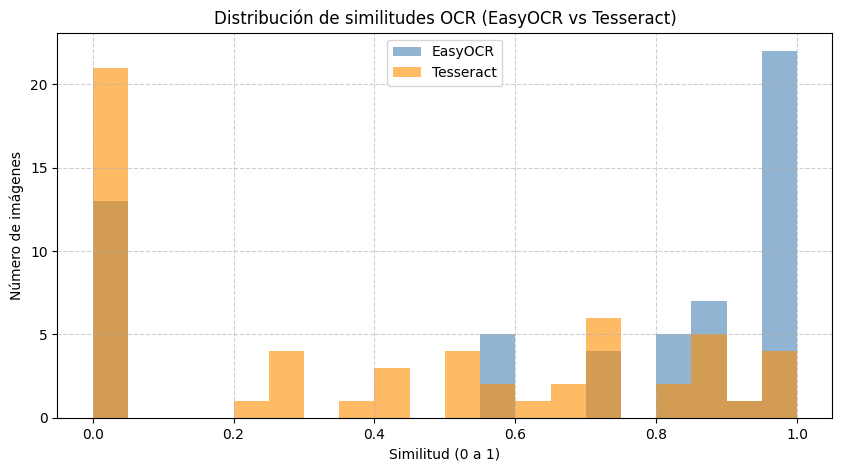

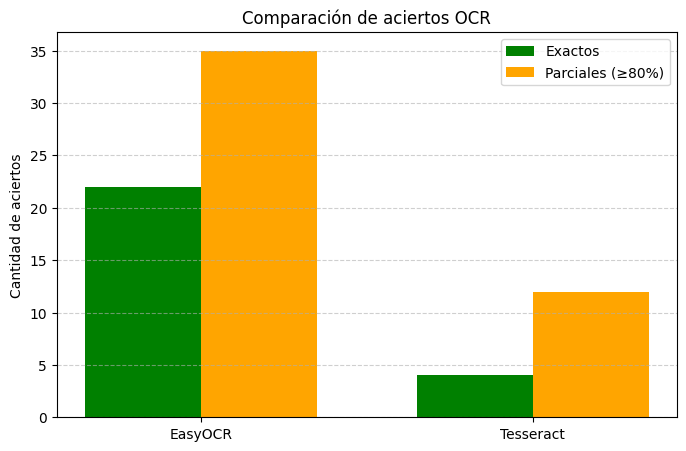

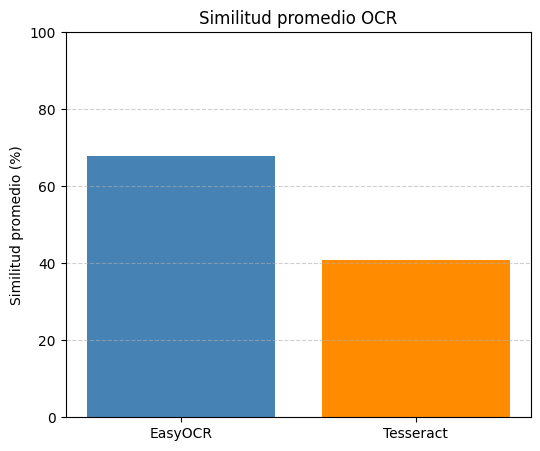

In [7]:
import os
import cv2
import pandas as pd
import numpy as np
from difflib import SequenceMatcher
import pytesseract
import easyocr
import matplotlib.pyplot as plt
from ultralytics import YOLO
import re

# === CONFIGURACIÓN ===
model_path = "matriculas_train/weights/best.pt"
base_dir = "TGC_RBNW/test"
img_dir = os.path.join(base_dir, "images")
output_csv = "CSVs/comparacion_test_easy_tesseract.csv"

# Inicializar modelos
model = YOLO(model_path)
model.overrides['verbose'] = False
reader = easyocr.Reader(['es'], gpu=True)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# === FUNCIÓN DE SIMILITUD ===
def similarity(a, b):
    return SequenceMatcher(None, str(a).strip(), str(b).strip()).ratio()


def reordenar_matricula(texto):
    """Corrige orden si las letras están antes de los números."""
    numeros = ''.join(re.findall(r'\d', texto))
    letras = ''.join(re.findall(r'[A-Z]', texto))
    if len(numeros) >= 4 and len(letras) >= 3:
        return numeros[:4] + letras[-3:]
    return texto

# === RESULTADOS ===
resultados = []

# Procesar cada imagen
for filename in os.listdir(img_dir):
    name, ext = os.path.splitext(filename)
    if ext.lower() not in [".jpg", ".jpeg", ".png"]:
        continue

    img_path = os.path.join(img_dir, filename)
    frame = cv2.imread(img_path)
    if frame is None:
        print(f"No se pudo leer {filename}")
        continue

    # Detección de matrícula
    results = model(frame)[0]
    texto_easy, texto_tess = "", ""

    for box in results.boxes:
        cls_id = int(box.cls[0])
        tipo = model.names[cls_id]
        if tipo.lower() != "matricula":
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        roi = frame[max(0, y1-5):min(frame.shape[0], y2+5),
                    max(0, x1-5):min(frame.shape[1], x2+5)]
        if roi.size == 0:
            continue

        # Preprocesamiento
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        roi_gray = cv2.resize(roi_gray, (300, int(roi_gray.shape[0]*300/roi_gray.shape[1])))
        roi_gray = cv2.adaptiveThreshold(
            roi_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )

        # OCR EasyOCR
        ocr_easy = reader.readtext(roi)
        texto_easy = "".join([r[1] for r in ocr_easy]).replace(" ", "").upper()
        texto_easy = reordenar_matricula(texto_easy)

        # OCR Tesseract
        config = "--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        texto_tess = pytesseract.image_to_string(roi_gray, config=config)
        texto_tess = texto_tess.strip().replace(" ", "").upper()
        texto_tess = reordenar_matricula(texto_tess)

    # Comparar con el nombre del archivo
    gt = name.upper()
    sim_easy = similarity(gt, texto_easy)
    sim_tess = similarity(gt, texto_tess)

    resultados.append({
        "archivo": filename,
        "matricula_real": gt,
        "easyocr": texto_easy,
        "tesseract": texto_tess,
        "similitud_easy": sim_easy,
        "similitud_tess": sim_tess
    })

# === DataFrame y métricas ===
df = pd.DataFrame(resultados)
df.to_csv(output_csv, index=False)
print(f"\nArchivo CSV guardado en: {output_csv}")

total = len(df)
exact_easy = (df["similitud_easy"] == 1.0).sum()
exact_tess = (df["similitud_tess"] == 1.0).sum()
partial_easy = (df["similitud_easy"] >= 0.8).sum()
partial_tess = (df["similitud_tess"] >= 0.8).sum()

print("\n--- RESULTADOS OCR SOBRE TEST ---")
print(f"Total de imágenes evaluadas: {total}")
print(f"EasyOCR - Aciertos exactos: {exact_easy} ({exact_easy/total*100:.2f}%) | Parciales (≥80%): {partial_easy} ({partial_easy/total*100:.2f}%) | Similitud promedio: {df['similitud_easy'].mean()*100:.2f}%")
print(f"Tesseract - Aciertos exactos: {exact_tess} ({exact_tess/total*100:.2f}%) | Parciales (≥80%): {partial_tess} ({partial_tess/total*100:.2f}%) | Similitud promedio: {df['similitud_tess'].mean()*100:.2f}%")

# === GRÁFICAS ===
plt.figure(figsize=(10, 5))
plt.hist(df["similitud_easy"], bins=20, alpha=0.6, label="EasyOCR", color="steelblue")
plt.hist(df["similitud_tess"], bins=20, alpha=0.6, label="Tesseract", color="darkorange")
plt.title("Distribución de similitudes OCR (EasyOCR vs Tesseract)")
plt.xlabel("Similitud (0 a 1)")
plt.ylabel("Número de imágenes")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Gráfico de barras (exactos y parciales)
plt.figure(figsize=(8, 5))
labels = ["EasyOCR", "Tesseract"]
exact_vals = [exact_easy, exact_tess]
partial_vals = [partial_easy, partial_tess]
bar_width = 0.35
x = np.arange(len(labels))

plt.bar(x - bar_width/2, exact_vals, width=bar_width, label="Exactos", color="green")
plt.bar(x + bar_width/2, partial_vals, width=bar_width, label="Parciales (≥80%)", color="orange")
plt.xticks(x, labels)
plt.ylabel("Cantidad de aciertos")
plt.title("Comparación de aciertos OCR")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Gráfico de promedio de similitud
plt.figure(figsize=(6, 5))
sim_means = [df["similitud_easy"].mean()*100, df["similitud_tess"].mean()*100]
plt.bar(labels, sim_means, color=["steelblue", "darkorange"])
plt.ylabel("Similitud promedio (%)")
plt.title("Similitud promedio OCR")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



0: 640x480 1 matricula, 98.5ms
Speed: 8.9ms preprocess, 98.5ms inference, 25.7ms postprocess per image at shape (1, 3, 640, 480)
[test.jpeg] Texto detectado: 4179HFR


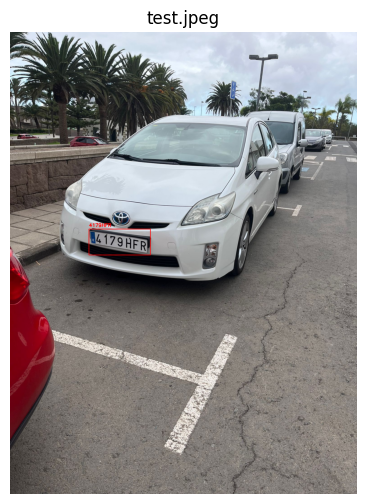


0: 640x480 1 matricula, 21.0ms
Speed: 4.7ms preprocess, 21.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 480)
[test2.jpeg] Texto detectado: 4T79HFR]


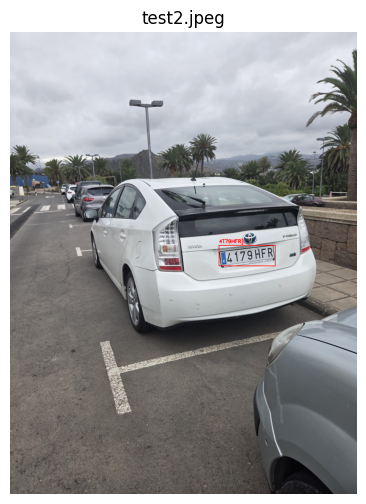

In [ ]:
import cv2
from ultralytics import YOLO
import easyocr
import matplotlib.pyplot as plt

# ===== CONFIG =====
model_path = "matriculas_train/weights/best.pt"
image_paths = ["test.jpeg", "test2.jpeg"]

# ===== Inicializar YOLO =====
model = YOLO(model_path)

# ===== Inicializar EasyOCR =====
reader = easyocr.Reader(['es'], gpu=True)

# ===== Procesar cada imagen =====
for image_path in image_paths:
    # Cargar imagen
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"No se pudo cargar la imagen {image_path}")
        continue

    # Detección
    results = model(frame)[0]

    # Procesar detecciones
    for box in results.boxes:
        cls_id = int(box.cls[0])
        tipo = model.names[cls_id]
        if tipo.lower() == "matricula":
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Padding
            pad = 5
            y1_p, y2_p = max(0, y1-pad), min(frame.shape[0], y2+pad)
            x1_p, x2_p = max(0, x1-pad), min(frame.shape[1], x2+pad)
            roi = frame[y1_p:y2_p, x1_p:x2_p]

            # OCR
            ocr_result = reader.readtext(roi)
            texto_matricula = " ".join([r[1] for r in ocr_result]) if ocr_result else ""
            print(f"[{image_path}] Texto detectado:", texto_matricula.strip().replace(" ", ""))

            # Dibujar recuadro
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,0,255), 2)
            cv2.putText(frame, texto_matricula.strip().replace(" ", ""), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    # Mostrar imagen con matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.title(image_path)
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()